# REFEED: Retrieval Feedback for Enhanced Model Outputs




REFEED (Retrieval Feedback) is an innovative framework designed to refine model outputs without the need for fine-tuning. By improving initial answers through the retrieval of relevant documents and adjusting responses based on new information, REFEED enhances the accuracy and reliability of generated content. This approach generates multiple answers to improve retrieval accuracy and combines pre- and post-retrieval outputs using a ranking system.



## Key Features of REFEED



- **Output Refinement**: The framework refines model outputs by incorporating retrieval feedback, enhancing the quality of initial responses.

- **Dynamic Retrieval Decisions**: REFEED dynamically decides when to retrieve external knowledge, balancing internal knowledge with external information sources.

- **Confidence Scoring**: Utilizes confidence scores from the language model's internal states to assess the necessity of retrieval, ensuring that only relevant information is accessed.

- **Honesty Probe**: Implements an honesty probe to help the model avoid hallucinations by aligning its output with its actual knowledge, thus improving factual accuracy.

- **Efficiency Improvement**: Reduces unnecessary retrievals, leading to enhanced efficiency and improved response accuracy.



## How REFEED Works



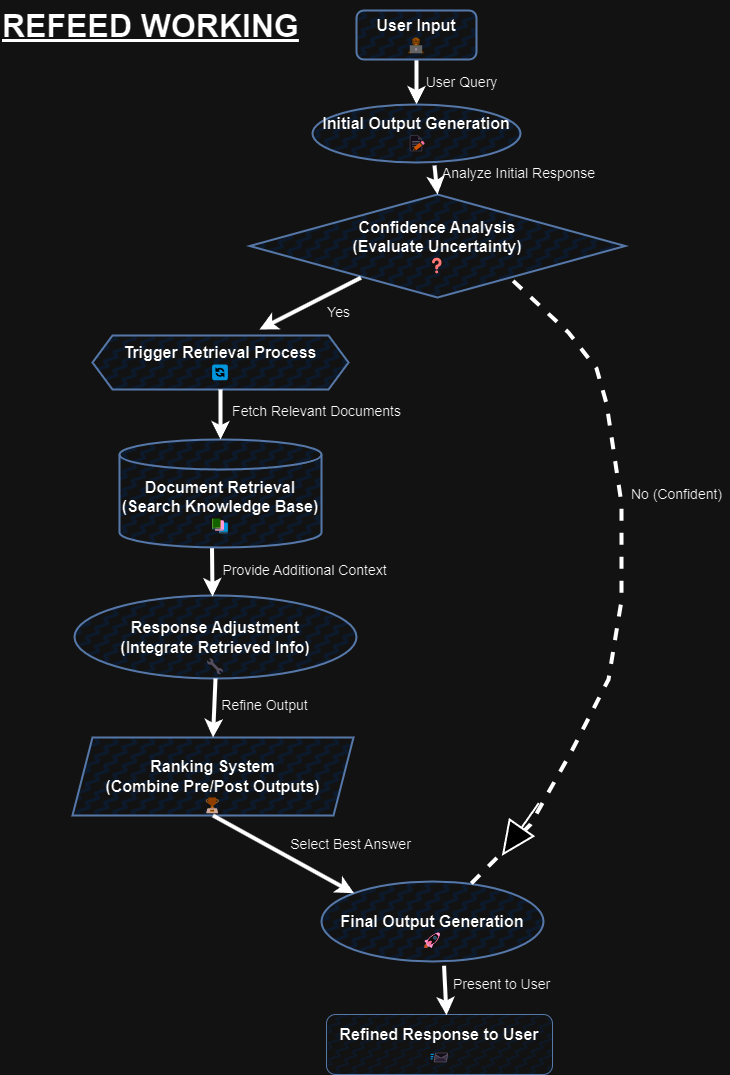

1. **Initial Output Generation**: The model generates an initial response based on user input and its internal knowledge base.

2. **Retrieval Triggering**: The system evaluates whether additional information is needed by analyzing confidence scores from its internal states. If scores indicate uncertainty, it triggers a retrieval process.

3. **Document Retrieval**: Relevant documents are retrieved from a knowledge base or external sources based on the initial output and context of the query.

4. **Response Adjustment**: The model adjusts its initial response using the newly retrieved information, refining its output for improved accuracy and relevance.

5. **Ranking System Application**: Pre- and post-retrieval outputs are combined using a ranking system to determine the most reliable answer based on contextual relevance and factual accuracy.

6. **Final Output Generation**: The refined response is generated and presented to the user, ensuring that it is coherent, accurate, and contextually appropriate.



In [ ]:
!pip install pypdf2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.5 MB/s eta 0:00:00


In [ ]:
!pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 3.5 MB/s eta 0:00:00


In [ ]:
import os
import requests
from PyPDF2 import PdfReader
from groq import Groq
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Step 0: Set up the Groq client
client = Groq(api_key="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")

In [ ]:
# Step 1: Download and Read the PDF
pdf_url = "https://arxiv.org/pdf/1810.04805.pdf"  # Example: BERT paper
pdf_path = "BERT_paper.pdf"

In [ ]:
response = requests.get(pdf_url)
with open(pdf_path, 'wb') as pdf_file:
    pdf_file.write(response.content)

In [ ]:
reader = PdfReader(pdf_path)
text = ""
for page in reader.pages:
    text += page.extract_text()

In [ ]:
# Step 2: Preprocess Text into Chunks
chunk_size = 1000
chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]
print(f"Number of chunks created: {len(chunks)}")

Number of chunks created: 65


In [ ]:
# Step 3: Initial Output Generation - Generate an Initial Response
user_query = "what is feature-based Approach with BERT?"

In [ ]:
def generate_initial_response(query):
    try:
        response_generation = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a response generation assistant."},
                {"role": "user", "content": f"Generate an initial response to the following query:\n\n{query}"},
            ],
            model="llama3-8b-8192",
        )
        return response_generation.choices[0].message.content
    except Exception as e:
        print(f"Error during initial response generation: {e}")
        return None

In [ ]:
initial_response = generate_initial_response(user_query)

In [ ]:
# Step 4: Retrieval Triggering - Evaluate Confidence Scores
def evaluate_confidence(response):
    try:
        confidence_response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a confidence assessment assistant."},
                {"role": "user", "content": f"Evaluate your confidence in this response:\n\n{response}"},
            ],
            model="llama3-8b-8192",
        )
        return confidence_response.choices[0].message.content
    except Exception as e:
        print(f"Error during confidence evaluation: {e}")
        return None

In [ ]:
confidence_score = evaluate_confidence(initial_response)

In [ ]:
# Step 5: Document Retrieval if Needed
def retrieve_documents(query):
    vectorizer = TfidfVectorizer()
    query_embedding = vectorizer.fit_transform([query])
    chunk_embeddings = vectorizer.transform(chunks)

    similarities = cosine_similarity(query_embedding, chunk_embeddings).flatten()
    top_k_indices = similarities.argsort()[-3:][::-1]  # Get top 3 relevant chunks
    return [chunks[i] for i in top_k_indices]

In [ ]:
needs_retrieval = "uncertainty" in confidence_score.lower()
retrieved_documents = retrieve_documents(user_query) if needs_retrieval else []

In [ ]:
# Step 6: Response Adjustment - Refine Initial Response with Retrieved Information
def adjust_response(initial, retrieved):
    context = initial + "\n\n" + "\n".join(retrieved)
    try:
        adjustment_response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a response adjustment assistant."},
                {"role": "user", "content": f"Adjust the following response using additional context:\n\n{context}"},
            ],
            model="llama3-8b-8192",
        )
        return adjustment_response.choices[0].message.content
    except Exception as e:
        print(f"Error during response adjustment: {e}")
        return None

In [ ]:
adjusted_response = adjust_response(initial_response, retrieved_documents) if needs_retrieval else initial_response

In [ ]:
# Step 7: Ranking System Application - Rank Pre- and Post-Retrieval Outputs
def rank_responses(initial, adjusted):
    try:
        ranking_response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a ranking assistant."},
                {"role": "user", "content": f"Rank the following responses based on relevance and accuracy:\n\nInitial Response:\n{initial}\n\nAdjusted Response:\n{adjusted}"},
            ],
            model="llama3-8b-8192",
        )
        return ranking_response.choices[0].message.content, adjusted  # Return both ranking and adjusted response
    except Exception as e:
        print(f"Error during ranking responses: {e}")
        return None, None

In [ ]:
final_ranked_output, final_adjusted_response = rank_responses(initial_response, adjusted_response)

In [ ]:
# Step 8: Final Output Generation - Deliver the Final Response
if final_ranked_output and final_adjusted_response:
    print("\n--- Final Output ---\n")
    print("Initial Response:\n")
    print(initial_response)
    print("\nAdjusted Response:\n")
    print(final_adjusted_response)
    print("\nRanking Feedback:\n")
    print(final_ranked_output)
else:
    print("No valid final output generated.")


--- Final Output ---

Initial Response:

The feature-based approach with BERT is a technique used to leverage the capabilities of the BERT (Bidirectional Encoder Representations from Transformers) language model for downstream natural language processing (NLP) tasks. In this approach, the BERT model is fine-tuned on a specific task and then used to extract relevant features from input texts. These features are typically in the form of contextualized token embeddings, sentence embeddings, or pooler outputs.

The feature-based approach with BERT can be applied in various ways, such as:

1. **Token-level features**: BERT can be used to extract token-level features, such as word embeddings, part-of-speech tags, named entity recognition, or dependency parsing, which can be used as input features for downstream tasks like text classification, sentiment analysis, or information retrieval.
2. **Sentence-level features**: BERT can also be used to extract sentence-level features, such as senten

### Explanation of the Code

The code is designed to handle a user query by performing several key steps: downloading a PDF, processing it, generating an initial response, evaluating the confidence of that response, retrieving relevant documents, refining the response with the retrieved information, ranking the responses, and ultimately delivering the final output. Let's break down each step:

### Step 0: Set up the Groq Client
- The `Groq` client is initialized using an API key to allow interaction with a response generation service. This is essential for sending queries and receiving answers.

### Step 1: Download and Read the PDF
- A PDF file from a given URL (in this case, the BERT paper from arXiv) is downloaded and saved locally.
- The file is then read, and the text is extracted page by page using a PDF reader.

### Step 2: Preprocess Text into Chunks
- The extracted text is split into chunks of 1000 characters each. This is done to make it easier to retrieve relevant portions of the document during the response generation process. This step reduces the processing load when searching for relevant content.

### Step 3: Initial Output Generation
- The query provided by the user is used to generate an initial response using the Groq client. This involves sending the query to a model (`llama3-8b-8192`) that generates a response based on the input.

### Step 4: Retrieval Triggering - Evaluate Confidence Scores
- The confidence of the initial response is evaluated by sending the generated response back to the Groq client. This step checks if the model is confident in its initial answer.
- If the confidence score is low or uncertain, the system decides that more document retrieval is necessary.

### Step 5: Document Retrieval if Needed
- If the confidence score indicates uncertainty, relevant document chunks are retrieved using the user's query. The `TfidfVectorizer` is used to compare the query with the chunks of text from the document, and the most relevant chunks are selected based on cosine similarity.

### Step 6: Response Adjustment - Refine Initial Response with Retrieved Information
- The initial response is then adjusted by adding context from the retrieved document chunks. This step ensures that the response is more accurate and grounded in the content from the document, particularly if the initial answer was vague or uncertain.

### Step 7: Ranking System Application
- After adjusting the response, the initial and adjusted responses are ranked based on relevance and accuracy. This step helps ensure that the most reliable and accurate response is presented to the user.

### Step 8: Final Output Generation
- The final response is delivered to the user. This includes both the initial response, the adjusted response, and any ranking feedback. If no valid output is generated, the system will notify the user that no response could be produced.



## Applications of REFEED



- **Customer Support Systems**: Enhances automated customer service interactions by providing accurate responses based on real-time data retrieval.

- **Knowledge Management Tools**: Assists organizations in synthesizing information from various sources while ensuring factual accuracy in reports and analyses.

- **Content Creation Platforms**: Supports writers by generating high-quality content that is well-informed and contextually relevant.

- **Educational Applications**: Provides learners with accurate information tailored to their queries, enhancing the educational experience through reliable feedback mechanisms.



## Advantages of REFEED



- **Improved Accuracy**: By incorporating relevant retrieved documents, REFEED enhances the factual accuracy of generated outputs.

- **Iterative Refinement**: The ability to generate multiple answers allows for a more thorough exploration of potential responses, leading to higher quality outputs.

- **Contextual Relevance**: By dynamically assessing when to retrieve information, REFEED ensures that responses are contextually relevant and aligned with user queries.

- **Resource Efficiency**: Reducing unnecessary retrievals minimizes computational costs and improves overall system efficiency.



## Limitations of REFEED



- **Complexity in Implementation**: Integrating retrieval feedback into existing models may introduce complexity in system design and require careful management.

- **Dependence on Quality of Retrieved Information**: The effectiveness of REFEED relies heavily on the quality and relevance of the retrieved documents; poor-quality sources can lead to inaccuracies.

- **Computational Overhead**: While it improves efficiency by reducing unnecessary retrievals, the process of generating multiple candidate responses may still require significant computational resources.



## Conclusion



REFEED represents a significant advancement in enhancing language models through effective retrieval feedback mechanisms. By refining outputs without fine-tuning, it improves accuracy and contextual relevance while maintaining efficiency. As AI continues to evolve, frameworks like REFEED will play a crucial role in delivering high-quality information that meets user needs effectively.



Having explored REFEED, we will now move on to Realm.